# Регуляризация

В рамках задания предлагается улучшить качество модели, подверженной переобучению.

Загрузим корпус MNIST и оставим 10000 тренировочных примеров.

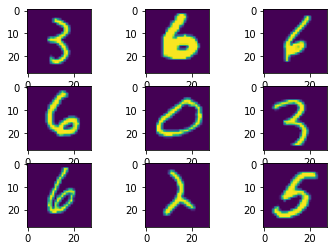

In [1]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
from tqdm import tqdm

USE_CUDA = torch.cuda.is_available()
print("USE CUDA:", USE_CUDA)

torch.manual_seed(0)
np.random.seed(0)

SUBSET_SIZE = 1000
BATCH_SIZE = 32

transform = torchvision.transforms.ToTensor()

train = MNIST("mnist", train=True, transform=transform, download=True)
train = torch.utils.data.Subset(train, np.random.permutation(len(train))[:SUBSET_SIZE])
test = MNIST("mnist", train=False, transform=transform, download=True)
print("Train size:", len(train))
print("Test size:", len(test))

def draw(dataset):
    images, labels = zip(*[dataset[i] for i in range(9)])
    fig, axs = plt.subplots(3, 3, squeeze=False)
    for i, image in enumerate(images):
        ax = axs[i // 3, i % 3]
        ax.imshow(image.permute(1, 2, 0).squeeze(-1))
    plt.show()

draw(train)

In [2]:
def compute_accuracy(model, loader):
    if USE_CUDA:
        model.cuda()
    model.eval()
    n_correct = 0
    n = 0
    for images, labels in loader:
        if USE_CUDA:
            images = images.cuda()
            labels = labels.cuda()
        n_correct += (model(images).argmax(dim=1) == labels).sum().item()
        n += len(images)
    return n_correct / n

In [24]:
def run(model, **optimizer_kwargs):
    print("Num parameters", sum(map(torch.numel, model.parameters())))
    if USE_CUDA:
        model.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=optimizer_kwargs.get("lr", 0.1),
                                **optimizer_kwargs)
    loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, drop_last=True)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
    test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)
    train_accuracies = []
    test_accuracies = []
    for epoch in range(23):
        model.train()
        losses = []
        for images, labels in loader:
            if USE_CUDA:
                images = images.cuda()
                labels = labels.cuda()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        model.eval()
        train_accuracy = compute_accuracy(model, loader)
        test_accuracy = compute_accuracy(model, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch}, loss {np.mean(losses):.3f}, train {train_accuracy:.3f}, test {test_accuracy:.3f}")
    print("Weights norm", torch.linalg.norm(torch.concat([p.flatten() for p in model.parameters()])).item())
    plt.ylim(train_accuracies[1], 1)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(train_accuracies, label="Train", marker="o")
    plt.plot(test_accuracies, label="Test", marker="o")
    plt.legend()
    plt.show()
    
torch.manual_seed(0)

# model = torch.nn.Sequential(
#     torch.nn.Conv2d(1, 4, 3, stride=2),
#     torch.nn.ReLU(),
#     torch.nn.Conv2d(4, 8, 3, stride=2),
#     torch.nn.ReLU(),
#     torch.nn.Flatten(),
#     torch.nn.Linear(288, 10)
# )
        
# run(model)

Num parameters 3226
Epoch 0, loss 2.292, train 0.321, test 0.294
Epoch 1, loss 2.232, train 0.502, test 0.464
Epoch 2, loss 1.644, train 0.728, test 0.681
Epoch 3, loss 0.864, train 0.845, test 0.820
Epoch 4, loss 0.596, train 0.877, test 0.844
Epoch 5, loss 0.507, train 0.887, test 0.854
Epoch 6, loss 0.462, train 0.899, test 0.857
Epoch 7, loss 0.431, train 0.904, test 0.859
Epoch 8, loss 0.411, train 0.909, test 0.861
Epoch 9, loss 0.394, train 0.915, test 0.863
Epoch 10, loss 0.381, train 0.919, test 0.865
Epoch 11, loss 0.370, train 0.919, test 0.867
Epoch 12, loss 0.362, train 0.921, test 0.867
Epoch 13, loss 0.355, train 0.920, test 0.868
Epoch 14, loss 0.348, train 0.921, test 0.869
Epoch 15, loss 0.343, train 0.924, test 0.870
Epoch 16, loss 0.338, train 0.924, test 0.870
Epoch 17, loss 0.334, train 0.922, test 0.871
Epoch 18, loss 0.330, train 0.925, test 0.872
Epoch 19, loss 0.327, train 0.928, test 0.873
Weights norm 3.9354088306427


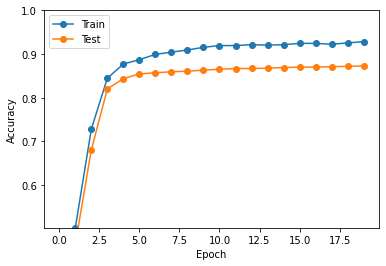

In [4]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10)
)

run(model, weight_decay=0.05)

При `weight_decay=0.05` точность на train падает на 4.3%, а на test на 1.4%. Таким образом переобучение становится меньше, но качество на test падает.

**Задание 1**. Может ли выбор `weight_decay` увеличить точность на train? Какой максимальной точности на test можно добиться подбором этого параметра? Может ли точность на train и test примерно сравняться?

Num parameters 3226
Epoch 0, loss 2.289, train 0.339, test 0.314
Epoch 1, loss 2.142, train 0.589, test 0.559
Epoch 2, loss 1.232, train 0.795, test 0.754
Epoch 3, loss 0.662, train 0.871, test 0.846
Epoch 4, loss 0.475, train 0.890, test 0.848
Epoch 5, loss 0.399, train 0.900, test 0.851
Epoch 6, loss 0.350, train 0.910, test 0.856
Epoch 7, loss 0.315, train 0.918, test 0.861
Epoch 8, loss 0.288, train 0.926, test 0.866
Epoch 9, loss 0.262, train 0.932, test 0.869
Epoch 10, loss 0.243, train 0.939, test 0.873
Epoch 11, loss 0.225, train 0.943, test 0.875
Epoch 12, loss 0.209, train 0.947, test 0.877
Epoch 13, loss 0.196, train 0.951, test 0.879
Epoch 14, loss 0.184, train 0.953, test 0.881
Epoch 15, loss 0.172, train 0.953, test 0.882
Epoch 16, loss 0.162, train 0.954, test 0.884
Epoch 17, loss 0.151, train 0.956, test 0.886
Epoch 18, loss 0.142, train 0.959, test 0.887
Epoch 19, loss 0.134, train 0.961, test 0.888
Epoch 20, loss 0.127, train 0.966, test 0.889
Epoch 21, loss 0.120, tr

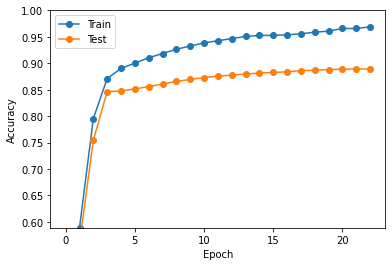

In [12]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10)
)

run(model, weight_decay=0.011)  # Ваш параметр.

**Задание 2.** Добавьте `torch.nn.Dropout`, подберите параметр и увеличьте точность на test до 90% или выше. Изменилось ли число параметров модели? Вырастает ли при этом точность на train?

Num parameters 3226
Epoch 0, loss 2.290, train 0.346, test 0.318
Epoch 1, loss 2.190, train 0.600, test 0.561
Epoch 2, loss 1.410, train 0.772, test 0.736
Epoch 3, loss 0.911, train 0.860, test 0.833
Epoch 4, loss 0.735, train 0.885, test 0.860
Epoch 5, loss 0.637, train 0.882, test 0.857
Epoch 6, loss 0.590, train 0.870, test 0.832
Epoch 7, loss 0.519, train 0.907, test 0.879
Epoch 8, loss 0.543, train 0.918, test 0.884
Epoch 9, loss 0.463, train 0.908, test 0.858
Epoch 10, loss 0.461, train 0.916, test 0.873
Epoch 11, loss 0.478, train 0.912, test 0.868
Epoch 12, loss 0.456, train 0.924, test 0.887
Epoch 13, loss 0.451, train 0.926, test 0.881
Epoch 14, loss 0.414, train 0.931, test 0.887
Epoch 15, loss 0.426, train 0.926, test 0.877
Epoch 16, loss 0.385, train 0.926, test 0.874
Epoch 17, loss 0.418, train 0.943, test 0.897
Epoch 18, loss 0.401, train 0.943, test 0.895
Epoch 19, loss 0.387, train 0.935, test 0.886
Epoch 20, loss 0.379, train 0.951, test 0.894
Epoch 21, loss 0.378, tr

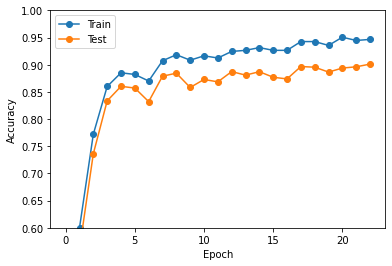

In [15]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10)
)  # Добавьте dropout в модель.

run(model, weight_decay=0.011)

**Задание 3** Добавить BatchNorm2d в модель. Изменилось ли при этом число параметров модели? Увеличьте точность на test до 89% или выше. Насколько можно увеличить точность на train?

Num parameters 3250
Epoch 0, loss 1.522, train 0.831, test 0.790
Epoch 1, loss 0.694, train 0.891, test 0.854
Epoch 2, loss 0.513, train 0.913, test 0.882
Epoch 3, loss 0.440, train 0.931, test 0.889
Epoch 4, loss 0.364, train 0.944, test 0.899
Epoch 5, loss 0.307, train 0.953, test 0.901
Epoch 6, loss 0.270, train 0.952, test 0.902
Epoch 7, loss 0.257, train 0.965, test 0.911
Epoch 8, loss 0.253, train 0.960, test 0.904
Epoch 9, loss 0.232, train 0.967, test 0.913
Epoch 10, loss 0.205, train 0.971, test 0.921
Epoch 11, loss 0.204, train 0.968, test 0.914
Epoch 12, loss 0.193, train 0.979, test 0.922
Epoch 13, loss 0.204, train 0.975, test 0.921
Epoch 14, loss 0.192, train 0.978, test 0.920
Epoch 15, loss 0.196, train 0.973, test 0.922
Epoch 16, loss 0.179, train 0.976, test 0.922
Epoch 17, loss 0.200, train 0.974, test 0.924
Epoch 18, loss 0.183, train 0.980, test 0.921
Epoch 19, loss 0.195, train 0.978, test 0.921
Epoch 20, loss 0.182, train 0.977, test 0.915
Epoch 21, loss 0.163, tr

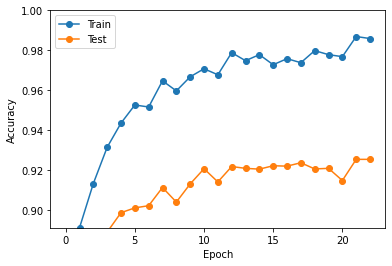

In [34]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.BatchNorm2d(4),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.BatchNorm2d(8),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10)
)  # Добавьте BatchNorm2d в модель (возможно несколько раз).

run(model, weight_decay=0.011)

**Задание 4.** Попробуйте добиться точности 92% или выше на test используя все предыдущие способы (можно добиться 93%+).

In [ ]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10)
)

run(model)